In [1]:
machine = 'mac'
machine = 'magny'


In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
%matplotlib inline

In [20]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black

In [3]:
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [10]:
istars, = np.where( (s.type == 4) & (s.halo == 0) & (s.r() > 0.) & (s.r() < s.galrad) )#& (s.r() > 0.) & (s.r() < Ngalrad*s.galrad) )
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, istars)

In [5]:
y_vals = np.sqrt(vR**2 + vz**2)
x_vals = vphi

NameError: name 'x_vals' is not defined

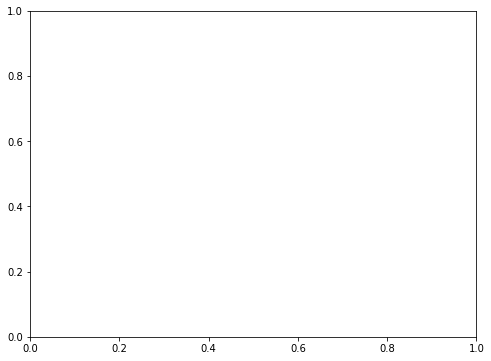

In [16]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black

fig, ax = plt.subplots(1, 1, figsize = (8,6))
h = ax.hist2d(x_vals, y_vals, bins = 401, norm=matplotlib.colors.LogNorm(), cmap = cmap)
ax.set_xlabel('$v_\phi$')
ax.set_ylabel('$\sqrt{v_R^2+v_z^2}$')
ax.set_title('Toomre diagram?!')

In [23]:
from areposnap.gadget import gadget_readenergy

efile = gadget_readenergy('/hits/universe/GigaGalaxy/level4_MHD/halo_24/output/')


In [32]:
efile.etots.shape


(6, 100)

Try to distinguish stellar disc and bulge components by the use of the circularity parameter $\epsilon = \frac{L_z}{L_{z,max}(E)}$.

$L_{z,max}(E)$ is the maximum angular momentum allowed for the orbital energy $E$. 

$\rightarrow \epsilon = 1$ is a prograde circular orbit in the disc plane. $\epsilon = -1$ is a retrograde circular orbit in the disc plane. $\epsilon \sim 0$ is an orbit with a very low $z$-component of angular momentum which may be highly inclined to the disc spin axis and/or be highly eccentric.  

Two methods two distinguish the components:
1. Mirror negative $\epsilon$ as bulge material, rest disc components.
2. Assign $\epsilon > 0.7$ to disc star particles.

see Grand et al. 2017

In [22]:
# plot energy over Lz

def momentum(m, vx, vy, vz):
    px, py, pz = m*vx, m*vy, m*vz
    return(px, py, pz)

def ang_mom(x, y, z, vx, vy, vz, m):
    px, py, pz = momentum(m, vx, vy, vz)
    Lx = y * pz - z * py
    Ly = z * px - x * pz
    Lz = x * py - y * px
    Jx = y * vz - z * vy
    Jy = z * vx - x * vz
    Jz = x * vy - y * vx    
    return((Lx, Ly, Lz), (Jx, Jy, Jz))

E = s.pot[istars] + 1./2. * s.mass[istars] * (vx**2 + vy**2)
E_wom
(Lx, Ly, Lz), (Jx, Jy, Jz) = ang_mom(x,y,z,vx,vy,vz,s.mass[istars])


Text(0.5,0,'E')

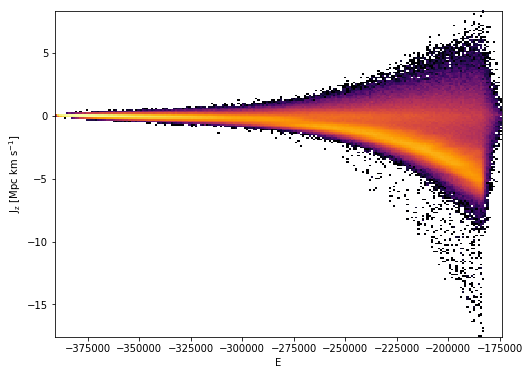

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
H = ax.hist2d(E, Jz, bins=201,  norm=matplotlib.colors.LogNorm(), cmap = plt.cm.inferno) # cmap = cmap
ax.set_ylabel("$\mathrm{J_z}\ [\mathrm{Mpc}\ \mathrm{km}\ \mathrm{s}^{-1}]$")
ax.set_xlabel("E")


[ -2.42559500e-07   3.48959482e-05  -1.01165047e-03  -9.90632233e-02
   1.35152991e+02]


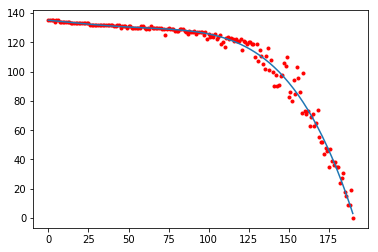

In [81]:
fit_arr = []
for i in range(201):
    min_val = np.nonzero(H[0][i])[0][0]
    fit_arr.append([i, min_val])
    if min_val == 0:
        break
fit_arr = np.array(fit_arr)
#print(fit_arr.shape)

x_vals = fit_arr[:, 0]
y_vals = fit_arr[:, 1]
#print(x_vals, y_vals)
plt.plot(x_vals, y_vals, 'r.')

z = np.polyfit(x_vals, y_vals, 4)
print(z)
p = np.poly1d(z)
plt.plot(x_vals,p(x_vals))

In [ ]:
### taken from The GigaGalaxy Project (analysis tool) / galaxy / plot_circularities_decomp_multi_age.py
Gcosmo = 43.0071


#input1 = '/home/marinafo/scratch/Aquarius/AgeOfAquariusOutputs/ExpansionList_short'
#input2 = '/home/marinafo/scratch/Aquarius/AgeOfAquariusOutputs/ExpansionList_128'

def plot_circularities_decomp_multi_age( runs, dirs, outpath, snap, suffix, nrows, ncols, normalize_bins=True ):
    panels = len(runs)
    figure = multipanel_layout.multipanel_layout( nrows=nrows, ncols=ncols, npanels=panels )
    figure.set_figure_layout()
    figure.set_axis_limits_and_aspect( xlim=[-2.0, 2.0], ylim=[0.0, 2.5] )
    if normalize_bins:
        figure.set_axis_locators( xminloc=0.25, xmajloc=1.0, yminloc=0.1, ymajloc=0.5 )
    else:
        figure.set_axis_locators( xminloc=0.25, xmajloc=1.0, yminloc=0.01, ymajloc=0.05 )

    figure.set_axis_labels( xlabel="$\epsilon$", ylabel="$\\rm{f(\epsilon)}$" )
    figure.set_fontsize()

    fileout = outpath + '/stellar_age.txt'
    f = open(fileout, 'w')
    header = "%12s%12s%12s\n" % ("Run", "Age disk", "Age bulge")
    f.write(header)

    savesnap = snap

        for d in range( len( runs ) ):
                dd = dirs[d] + runs[d]
        ax = figure.axes[d]

                print("Doing dir %s snap %d." % (dd, snap))

        s = gadget_readsnap( snap, snappath=dd+'/output/', hdf5=True, loadonly=['pos', 'vel', 'mass', 'pot', 'age'] )
        sf = load_subfind( snap, dir=dd+'/output/', hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty'] )
        s.calc_sf_indizes( sf, dosubhalos=False, halolist=[0] )
        na = s.nparticlesall

            galrad = 0.1 * sf.data['frc2'][0]
            print('galrad:', galrad)
        center = None
        age_select = 3.
        s.select_halo( sf, center, age_select, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

        print('select particle properties')

        mass = s.data['mass'].astype('float64')
        st = na[:4].sum(); en = st+na[4]
        age = np.zeros( s.npartall )
        age[st:en] = s.data['age']

        iall, = np.where( (s.r() < galrad) & (s.r() > 0.) )
        istars, = np.where( (s.r() < galrad) & (s.r() > 0.) & (s.type == 4) & (age > 0.) )

            nstars = size( istars )
            nall   = size( iall )
            rr = pylab.sqrt( (s.pos[iall,:]**2).sum(axis=1) )
            msort = rr.argsort()
            mass_all = mass[iall]
        
            msum = pylab.zeros( nall )
        msum[msort[:]] = np.cumsum(mass_all[msort[:]])

            pos  = s.pos[iall,:].astype( 'float64' )
            vel = s.vel[iall,:].astype( 'float64' )
            mass = s.data['mass'][iall].astype( 'float64' )
            ptype = s.data['type'][iall]
            pot = s.data['pot'][iall].astype('float64')
                #radius = pylab.sqrt( (s.pos[iall,1:]**2).sum(axis=1) ) # radius in yz (disc) plane??
                radius = pylab.sqrt( (s.pos[iall,:]**2).sum(axis=1) )
		age = age[iall]

        	eps   = pylab.zeros( nstars )
		eps2  = pylab.zeros( nstars )
        	smass = pylab.zeros( nstars )
        	cosalpha = pylab.zeros( nstars )
        	jcmax = pylab.zeros( nstars )
		spec_energy = pylab.zeros( nstars )
		star_age = pylab.zeros( nstars )

		#computing stellar properties
		print('computing star properties')
		nn, = np.where((ptype[:] == 4) & (age[:] > 0.)) 

               	j  = pylab.cross( pos[nn,:], vel[nn,:] )
                jc = radius[nn] * pylab.sqrt( Gcosmo * msum[nn] / radius[nn] )
                jz = j[:,0]

		spec_energy[:] = 0.5 * (vel[nn,:]**2).sum(axis=1) + pot[nn]
		eps[:] = jz / jc
		eps2[:] = jz
                smass[:] = mass[nn]
                cosalpha[:] = jz / np.sqrt( (j[:]**2).sum(axis=1) )
		star_age[:] = s.cosmology_get_lookback_time_from_a( age[nn], is_flat=True )

		print('computing histograms')

		#sort particle by specific energy
		iensort = np.argsort(spec_energy)
		eps = eps[iensort]
		eps2 = eps2[iensort]
		spec_energy = spec_energy[iensort]
		smass = smass[iensort]
		cosalpha = cosalpha[iensort]
		star_age = star_age[iensort]

        	for nn in range( nstars ):
			nn0 = nn - 50
			nn1 = nn + 50

			if nn0 < 0:
				nn1 += -nn0
				nn0 = 0
			if nn1 >= nstars:
				nn0 -= ( nn1 - (nstars - 1) )
				nn1 = nstars - 1

			jcmax[nn] = np.max( eps2[nn0:nn1] )

        	smass /= smass.sum()
		eps2[:] /= jcmax[:]

       		#compute total new (it is used for bulge disk decomposition and plotted afterwards)
		ydatatot, edges = histogram( eps2, bins=100, weights=smass, range=[-1.7,1.7] )
		xdatatot = 0.5 * (edges[1:] + edges[:-1])

		kk, = np.where( xdatatot <= 0.0 )
		pivot = np.max( kk )

		#such that \int f(\epsilon) d\epsilon = 1
		if normalize_bins:
			binwidth = edges[1:] - edges[:-1]
			ydatatot[:] /= binwidth[:]

		xdata = np.zeros( len ( xdatatot ) )
		ydata = np.zeros( len ( ydatatot ) )
		ydatad = np.zeros( len ( ydatatot ) )

        	#bulge	
		ydata[:] = ydatatot[:]
		xdata[:] = xdatatot[:]
		#mirror part with negative epsilon (if that is too big keep the actual value)
		if len( ydata ) % 2 == 0: 
			for i in range( 0, len( ydata ) / 2 ):
				if ydata[pivot + i + 1] > ydata[pivot - i]:
					ydata[pivot + i + 1] = ydata[pivot - i]
		else:
			for i in range( 1, len( ydata ) / 2 ):
				if ydata[pivot + i] > ydata[pivot - i]:
					ydata[pivot + i] = ydata[pivot - i]

		ax.fill( xdata, ydata, fc='r', alpha=0.5, fill=True, lw=0, label='spheroid' )

		#disk
		ydatad[:] = ydatatot[:]
		xdata[:] = xdatatot[:]
		#substract the bulge part
		ydatad[:] -= ydata[:]
		ax.fill( xdata, ydatad, fc='b', alpha=0.5, fill=True, lw=0, label='disc' )
		#multiply by bin width if bin have been normalised
		if normalize_bins:
			binwidth = edges[1:] - edges[:-1]
			ydatad[:] *= binwidth[:]

       		#plot total new
		ax.plot( xdatatot, ydatatot, 'k', label='total' )

		#total old
		ydata, edges = histogram( eps, bins=100, weights=smass, range=[-1.7,1.7] )
		xdata = 0.5 * (edges[1:] + edges[:-1])

		#such that \int f(\epsilon) d\epsilon = 1
		if normalize_bins:
			binwidth = edges[1:] - edges[:-1]
			ydata[:] /= binwidth[:]

		jj, = np.where( (eps2 > 0.7) & (eps2 < 1.7) )
		kk, = np.where( (eps2 > -1.7) & (eps2 <= 0.7) )
		ll, = np.where( (eps2 > -1.7) & (eps2 < 1.7) )
		alt_frac = smass[jj].sum() / smass[ll].sum()

		age_disk = (star_age[jj] * smass[jj]).sum() / smass[jj].sum()
		age_bulge = (star_age[kk] * smass[kk]).sum() / smass[kk].sum()
		header = "%12s%12.2f%12.2f\n" % (runs[d], age_disk, age_bulge)
		f.write(header)

		ax.plot( xdata, ydata, 'gray', lw=0.7, label="$\\rm{f(\\epsilon_{v})}$" )

        	ax.legend( loc='upper left', frameon=False, prop={'size':5} )
		ax.text( 0.06, 0.60, "D/T = %4.2f [%4.2f]" % (alt_frac, ydatad.sum()), size=5, transform=ax.transAxes )

		figure.set_panel_title(panel=d, title="$\\rm{%s-{%s}}$" % (runs[d].split('_')[0], runs[d].split('_')[1]), position='top right' )

	f.close()
	#figure.fig.savefig( '%s/epsilon_multi_age%03d.%s' % (outpath, snap, suffix) )
